# Question 3 How can we improve the efficiency of our supply chain?

### Imports

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path ="data/amazon_delivery.csv"
df= pd.read_csv(file_path)

print(df.head())
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)  
pd.set_option('display.max_colwidth', None) 

        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    High   motorcycle

# Step 1: Data Preparation and Cleaning
## Check for missing values

In [3]:
print(df.isnull().sum())
df = df.dropna() #51 rows of agent rating and 91 rows of weather dropped since <1% of data

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64


## Convert columns to appropriate formats

In [4]:
# Convert Order_Time and Pickup_Time to datetime
df['Order_Time'] = pd.to_datetime(df['Order_Time'], format='%H:%M:%S').dt.time
df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], format='%H:%M:%S').dt.time

# Convert Order_Date to datetime format
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Step 2: EDA & Feature Engineering


## Calculate Order-Pickup Lag

In [5]:
#Combine Order_Date with times
df['Order_DateTime'] = pd.to_datetime(df['Order_Date'].astype(str) + ' ' + df['Order_Time'].astype(str))
df['Pickup_DateTime'] = pd.to_datetime(df['Order_Date'].astype(str) + ' ' + df['Pickup_Time'].astype(str))

#Calculate lag between order and pickup(in minutes)
df['Order_Pickup_Lag'] = (df['Pickup_DateTime'] - df['Order_DateTime']).dt.total_seconds() / 60
print(df.head())

        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time Pickup_Time     Weather  Traffic      Vehicle            Area  Delivery_Time     Category      Order_DateTime     Pickup_DateTime  Order_Pickup_Lag
0  ialx566343618         37           4.9       22.745049        75.892471      22.765049       75.912471 2022-03-19   11:30:00    11:45:00       Sunny    High   motorcycle           Urban             120     Clothing 2022-03-19 11:30:00 2022-03-19 11:45:00              15.0
1  akqg208421122         34           4.5       12.913041        77.683237      13.043041       77.813237 2022-03-25   19:45:00    19:50:00      Stormy     Jam      scooter   Metropolitian             165  Electronics 2022-03-25 19:45:00 2022-03-25 19:50:00               5.0
2  njpu434582536         23           4.4       12.914264        77.678400      12.924264       77.688400 2022-03-19   08:30:00    08:45:00  Sandstorms     Low   motorcycle

## Calculate Geographical Distance using Haversine formula:

In [6]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371  # Radius of the Earth in km
    return R * c

# Apply the function to calculate distance for each row
df['Distance_km'] = df.apply(lambda row: haversine(row['Store_Latitude'], 
                                                   row['Store_Longitude'], 
                                                   row['Drop_Latitude'], 
                                                   row['Drop_Longitude']), axis=1)
print(df.head())


        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time Pickup_Time     Weather  Traffic      Vehicle            Area  Delivery_Time     Category      Order_DateTime     Pickup_DateTime  Order_Pickup_Lag  Distance_km
0  ialx566343618         37           4.9       22.745049        75.892471      22.765049       75.912471 2022-03-19   11:30:00    11:45:00       Sunny    High   motorcycle           Urban             120     Clothing 2022-03-19 11:30:00 2022-03-19 11:45:00              15.0     3.025149
1  akqg208421122         34           4.5       12.913041        77.683237      13.043041       77.813237 2022-03-25   19:45:00    19:50:00      Stormy     Jam      scooter   Metropolitian             165  Electronics 2022-03-25 19:45:00 2022-03-25 19:50:00               5.0    20.183530
2  njpu434582536         23           4.4       12.914264        77.678400      12.924264       77.688400 2022-03-19   08:30:00    08

## Summary of Delivery time and order pick up lag

In [7]:
print(df[['Delivery_Time', 'Order_Pickup_Lag']].describe())

sum_suppliers = df[['Store_Latitude', 'Store_Longitude']].drop_duplicates()
sum_suppliers.shape[0]

       Delivery_Time  Order_Pickup_Lag
count   43594.000000      43594.000000
mean      124.916433        -17.260403
std        51.941975        196.015502
min        10.000000      -1435.000000
25%        90.000000          5.000000
50%       125.000000         10.000000
75%       160.000000         15.000000
max       270.000000         15.000000


489

## Delivery Time

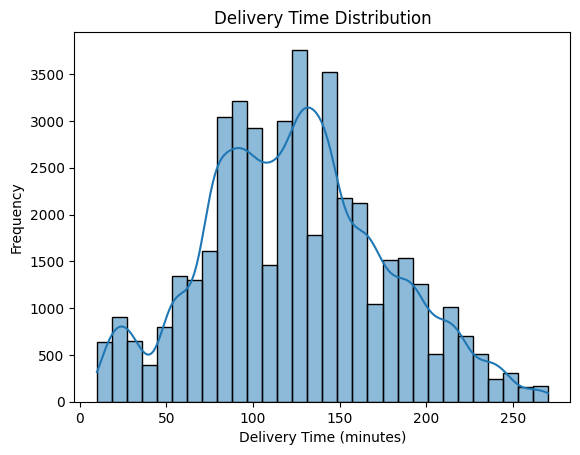

In [8]:
sns.histplot(df['Delivery_Time'], bins=30, kde=True)
plt.title('Delivery Time Distribution')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Calculate average metrics for each store
store_performance = df.groupby(['Store_Latitude', 'Store_Longitude']).agg(
    avg_agent_rating=('Agent_Rating', 'mean'),
    avg_order_pickup_lag=('Order_Pickup_Lag', 'mean'),
    avg_delivery_time=('Delivery_Time', 'mean')
).reset_index()

# Display the result
print(store_performance)


     Store_Latitude  Store_Longitude  avg_agent_rating  avg_order_pickup_lag  avg_delivery_time
0        -30.902872        75.826808          4.850000             10.000000         112.500000
1        -30.899584        75.809346          4.750000             12.500000         127.500000
2        -30.895817        75.813112          4.433333           -475.000000         106.666667
3        -30.893244        75.821817          4.800000              5.000000         105.000000
4        -30.892978        75.821847          4.900000             10.000000          55.000000
..              ...              ...               ...                   ...                ...
484       30.899584        75.809346          4.640000            -26.125000         121.250000
485       30.899992        75.831338          4.640541             10.135135         128.243243
486       30.902872        75.826808          4.625806              9.032258         133.870968
487       30.905562        75.832841    

## Deeper Analysis into Supplier Performance

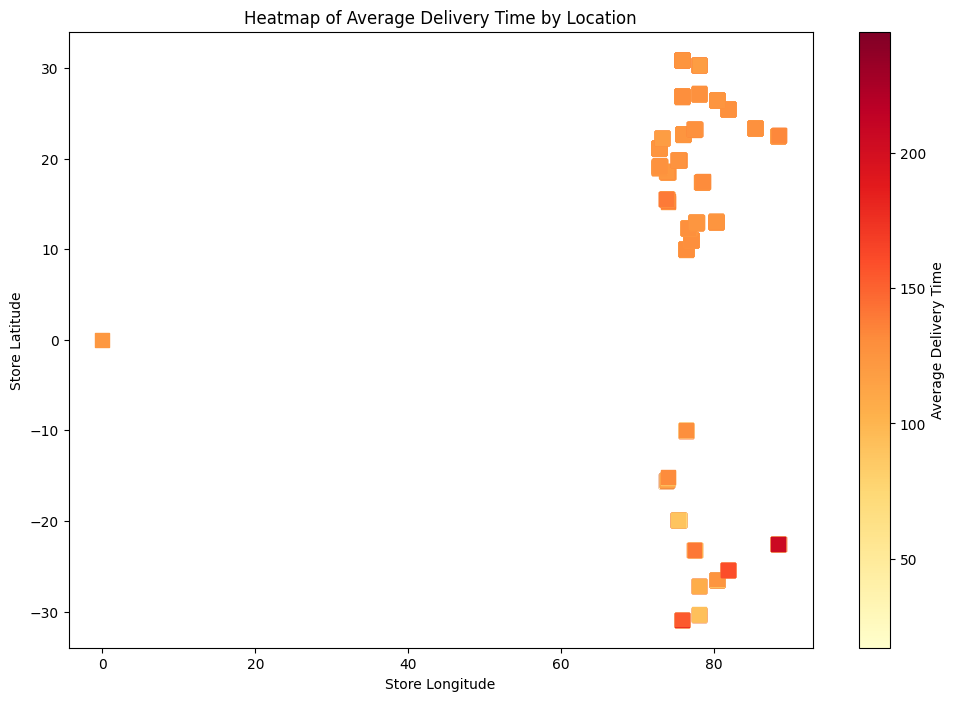

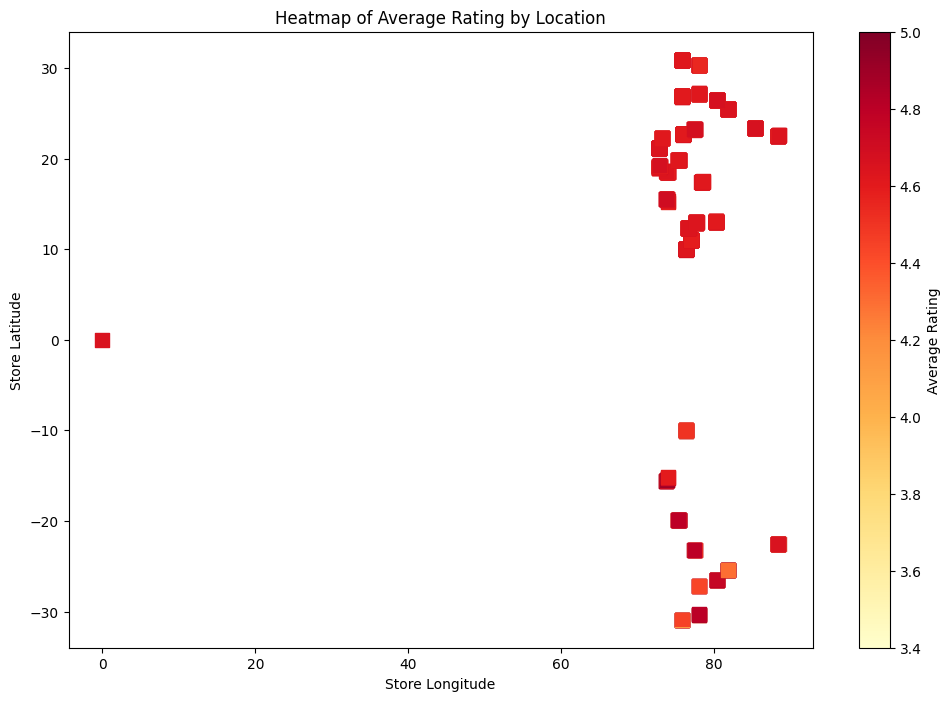

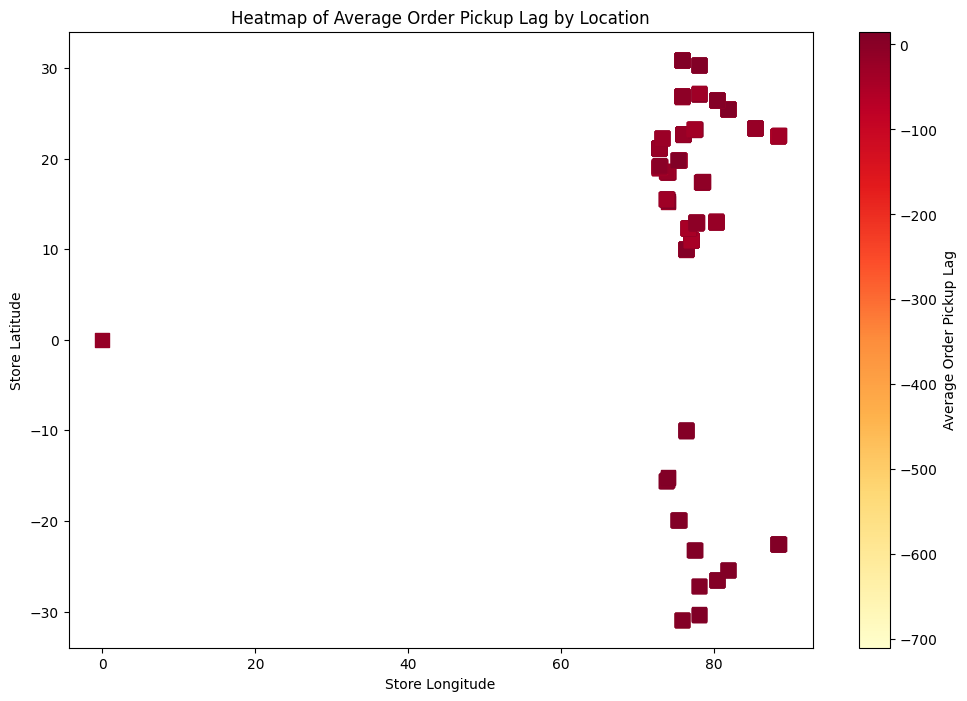

In [10]:
plt.figure(figsize=(12, 8))
heatmap = plt.scatter(
    x=store_performance['Store_Longitude'],
    y=store_performance['Store_Latitude'],
    c=store_performance['avg_delivery_time'],
    cmap='YlOrRd',
    s=100,  # Fixed size for better comparison
    marker='s'
)
plt.colorbar(heatmap, label='Average Delivery Time')
plt.xlabel('Store Longitude')
plt.ylabel('Store Latitude')
plt.title('Heatmap of Average Delivery Time by Location')
plt.show()

plt.figure(figsize=(12, 8))
heatmap = plt.scatter(
    x=store_performance['Store_Longitude'],
    y=store_performance['Store_Latitude'],
    c=store_performance['avg_agent_rating'],
    cmap='YlOrRd',
    s=100,  # Fixed size for better comparison
    marker='s'
)
plt.colorbar(heatmap, label='Average Rating')
plt.xlabel('Store Longitude')
plt.ylabel('Store Latitude')
plt.title('Heatmap of Average Rating by Location')
plt.show()

plt.figure(figsize=(12, 8))
heatmap = plt.scatter(
    x=store_performance['Store_Longitude'],
    y=store_performance['Store_Latitude'],
    c=store_performance['avg_order_pickup_lag'],
    cmap='YlOrRd',
    s=100,  # Fixed size for better comparison
    marker='s'
)
plt.colorbar(heatmap, label='Average Order Pickup Lag')
plt.xlabel('Store Longitude')
plt.ylabel('Store Latitude')
plt.title('Heatmap of Average Order Pickup Lag by Location')
plt.show()

### 1. Heatmap of Average Delivery Time by Location  
Insights: Locations with darker shades (closer to red) have higher average delivery times, indicating that deliveries in these areas take longer.  
Potential Bottlenecks: Areas with high delivery times suggest inefficiencies or delays, which may stem from logistical challenges, traffic congestion, or inadequate resources in these regions.  

### 2. Heatmap of Average Rating by Location
Insights: Locations with darker colors indicate lower ratings, suggesting lower customer satisfaction in these areas.  
Potential Bottlenecks: Lower ratings could be linked to longer delivery times, which negatively affect customer experience. Identifying and addressing the causes of these delays can improve customer ratings.  

### 3. Heatmap of Average Order Pickup Lag by Location
Insights: Areas with high average order pickup lag (darker colors) reflect slower response times from suppliers in processing orders for pickup.  
Potential Bottlenecks: High pickup lags could be due to operational delays or resource constraints, impacting the overall delivery time. Locations with high pickup lag should be prioritized for process optimization.

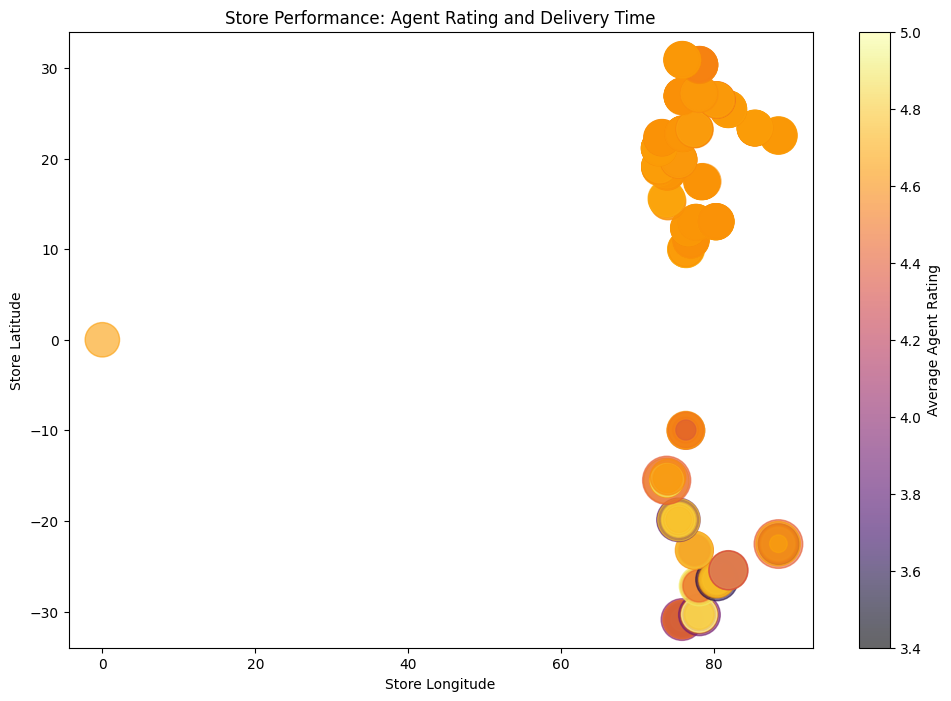

c:\Users\65977\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


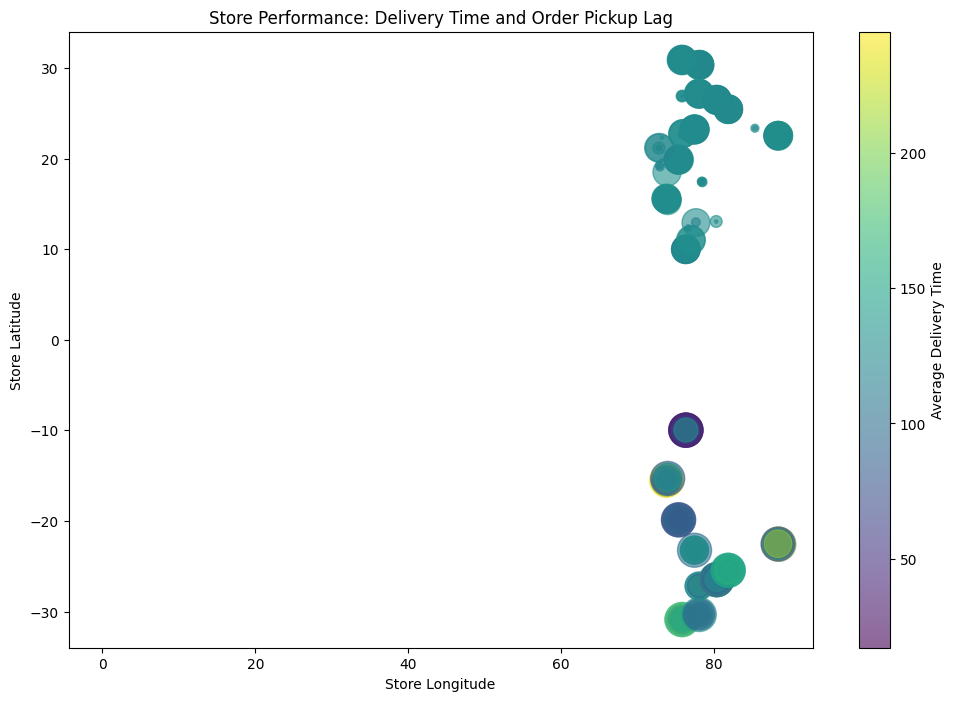

In [11]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=store_performance['Store_Longitude'],
    y=store_performance['Store_Latitude'],
    c=store_performance['avg_agent_rating'],
    s=store_performance['avg_delivery_time'] * 5,  # Adjust size scale for visibility
    cmap='inferno',
    alpha=0.6
)
plt.colorbar(scatter, label='Average Agent Rating')
plt.xlabel('Store Longitude')
plt.ylabel('Store Latitude')
plt.title('Store Performance: Agent Rating and Delivery Time')
plt.show()


plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=store_performance['Store_Longitude'],
    y=store_performance['Store_Latitude'],
    c=store_performance['avg_delivery_time'],  # Color by average delivery time
    s=store_performance['avg_order_pickup_lag'] * 40,  # Size by order pickup lag, scaled for visibility
    cmap='viridis',  # Color map to reflect delivery time range
    alpha=0.6
)

# Add color bar and labels
plt.colorbar(scatter, label='Average Delivery Time')
plt.xlabel('Store Longitude')
plt.ylabel('Store Latitude')
plt.title('Store Performance: Delivery Time and Order Pickup Lag')
plt.show()


### 1. Scatter Plot of Average Agent Rating and Delivery Time
Insights: This plot shows both agent ratings and delivery times. Locations with larger, darker points indicate both high delivery times and lower ratings.  
Potential Bottlenecks: Locations with large points (high delivery times) and darker colors (low ratings) are key bottlenecks. These areas could benefit from additional resources or operational improvements.  

### 2. Scatter Plot of Delivery Time and Order Pickup Lag
Insights: Points with larger sizes indicate high order pickup lag, while color indicates delivery time. Larger, darker points indicate regions with both high pickup lag and high delivery times.  
Potential Bottlenecks: Locations with both high pickup lag and delivery time need targeted interventions, such as increasing staff or streamlining the pickup process to reduce delays.  

### Overall Summary:  
High-Risk Locations: Locations with high delivery times, low ratings, and high pickup lag are the primary bottlenecks.  
Plan Targeted Improvements: For these areas, consider increasing staffing, optimizing delivery routes, or improving pickup processes to reduce delays.  
Monitor Key Metrics: Regularly monitor these metrics to assess the impact of interventions and maintain customer satisfaction.

## Identify stores with the highest average delivery times

In [12]:
avg_delivery_by_store = df.groupby(['Store_Latitude', 'Store_Longitude']).agg({'Delivery_Time': 'mean'}).reset_index()

# Identify stores with the highest average delivery times
bottlenecks = avg_delivery_by_store.sort_values(by='Delivery_Time', ascending=False).head(10)

print(bottlenecks)

    Store_Latitude  Store_Longitude  Delivery_Time
53      -22.549100        88.400467          245.0
82      -15.513150        73.783460          240.0
79      -15.561550        73.749092          215.0
62      -22.514119        88.362504          205.0
65      -19.879631        75.323403          195.0
26      -26.473698        80.352677          185.0
71      -19.875522        75.367127          185.0
64      -19.880256        75.323503          180.0
6       -30.885814        75.786976          180.0
9       -30.361281        78.068022          180.0


## Top Bottlenecks

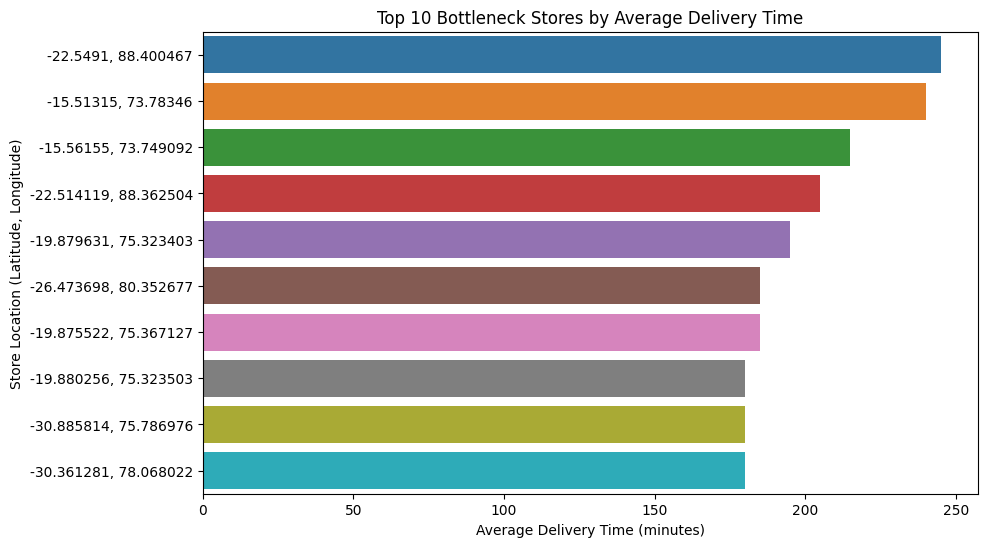

In [13]:
#Create a combined column for Latitude and Longitude
bottlenecks['Store_Location'] = bottlenecks['Store_Latitude'].astype(str) + ", " + bottlenecks['Store_Longitude'].astype(str)

#Plot the bar chart with combined Latitude and Longitude labels
plt.figure(figsize=(10, 6))
sns.barplot(x='Delivery_Time', y='Store_Location', data=bottlenecks.sort_values(by='Delivery_Time', ascending=False))
plt.title('Top 10 Bottleneck Stores by Average Delivery Time')
plt.xlabel('Average Delivery Time (minutes)')
plt.ylabel('Store Location (Latitude, Longitude)')
plt.show()


## Visualize Delivery Time vs Key Factors:

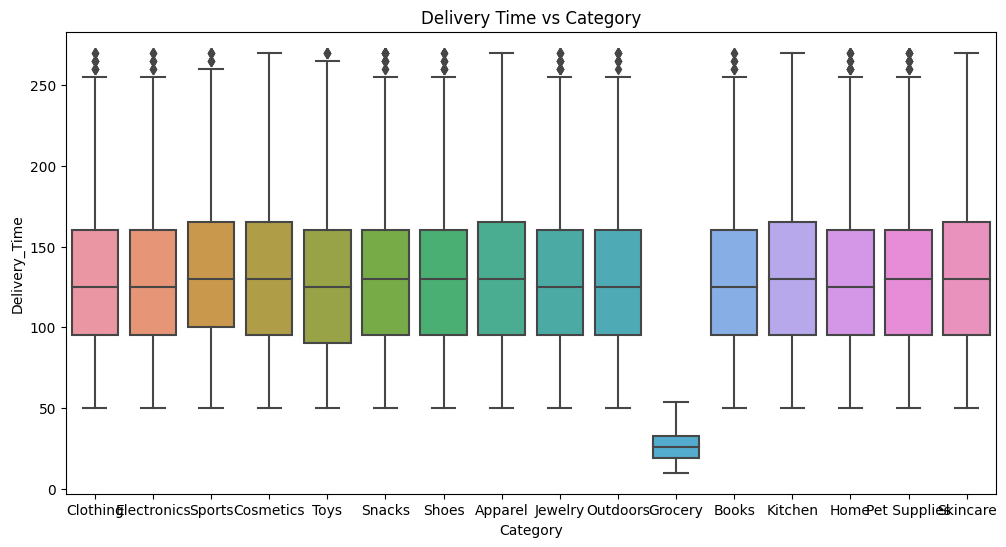

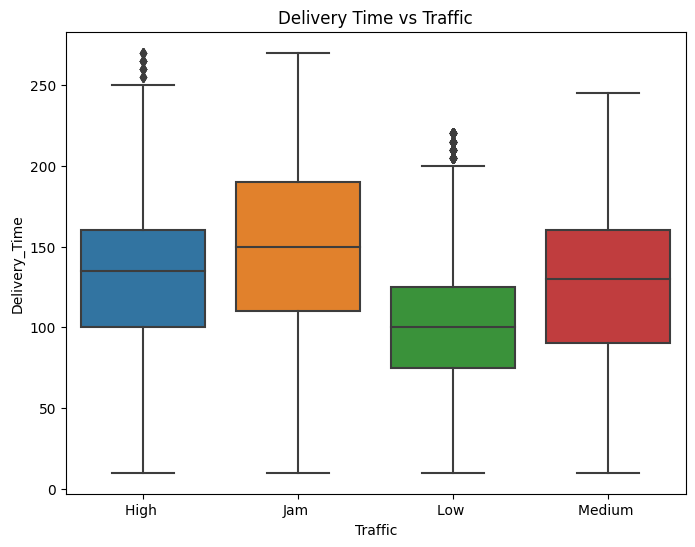

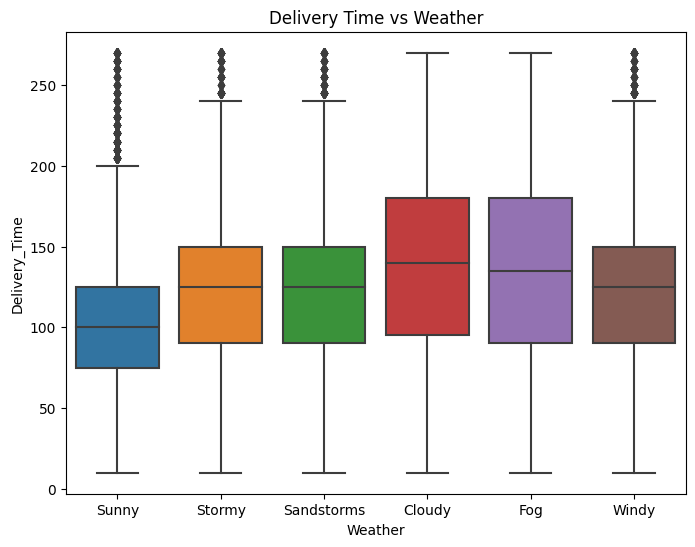

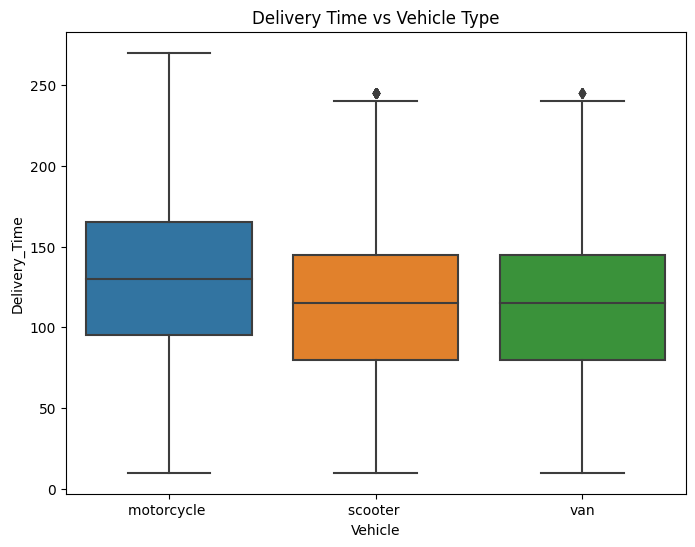

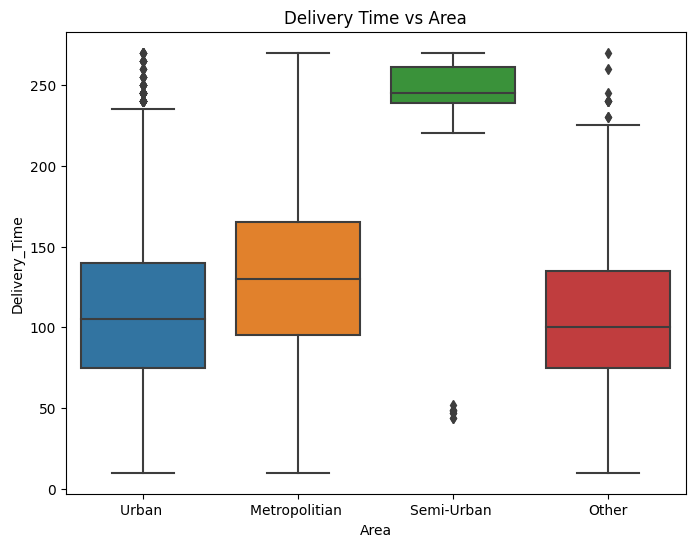

C:\Users\65977\AppData\Local\Temp\ipykernel_12212\1778499588.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Agent_Rating', y='Delivery_Time', data=df, marker='o', ci=None)


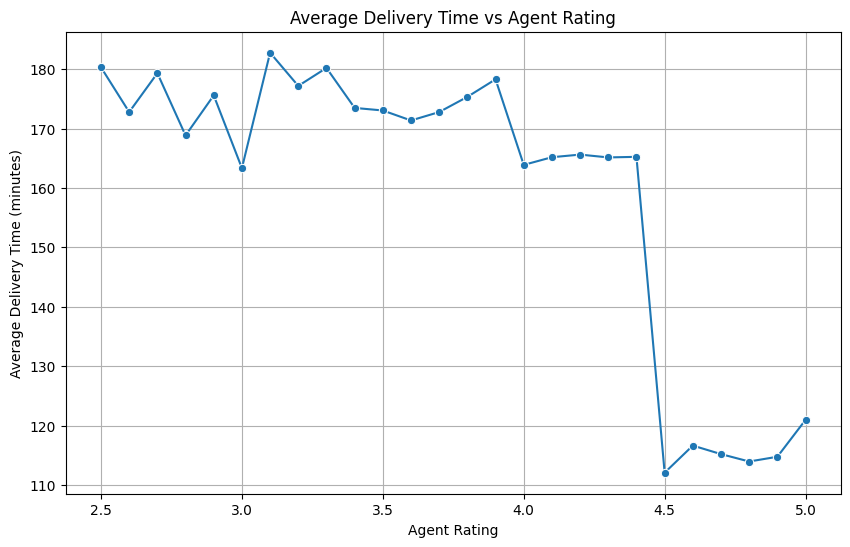

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Delivery_Time')
plt.title('Delivery Time vs Category')
plt.show()

# Delivery Time vs Traffic
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Traffic', y='Delivery_Time')
plt.title('Delivery Time vs Traffic')
plt.show()

# Delivery Time vs Weather
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Weather', y='Delivery_Time')
plt.title('Delivery Time vs Weather')
plt.show()

# Delivery Time vs Vehicle Type
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Vehicle', y='Delivery_Time')
plt.title('Delivery Time vs Vehicle Type')
plt.show()

# Delivery Time vs Area
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Area', y='Delivery_Time')
plt.title('Delivery Time vs Area')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Agent_Rating', y='Delivery_Time', data=df, marker='o', ci=None)
plt.title("Average Delivery Time vs Agent Rating")
plt.xlabel("Agent Rating")
plt.ylabel("Average Delivery Time (minutes)")
plt.grid(True)
plt.show()



## Graphs for presentation

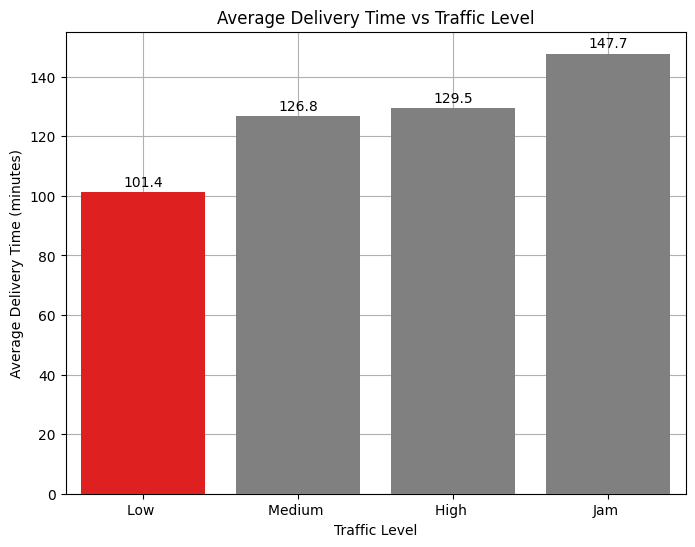

In [18]:
# Calculate the average delivery time by traffic level (if not already calculated)
average_delivery_time_by_traffic = df.groupby('Traffic')['Delivery_Time'].mean().reset_index()

# Sort the DataFrame in ascending order of Delivery_Time
average_delivery_time_by_traffic = average_delivery_time_by_traffic.sort_values(by='Delivery_Time', ascending=True)

# Extract the sorted traffic levels
sorted_traffic_levels = average_delivery_time_by_traffic['Traffic'].tolist()

# Define custom colors: red for "Low" traffic, grey for others
colors = ['red' if traffic == 'Low ' else 'grey' for traffic in sorted_traffic_levels]

# Plotting with custom colors
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=average_delivery_time_by_traffic, x='Traffic', y='Delivery_Time', order=sorted_traffic_levels, palette=colors, zorder=3)
plt.title('Average Delivery Time vs Traffic Level')
plt.xlabel('Traffic Level')
plt.ylabel('Average Delivery Time (minutes)')
plt.grid(True, zorder=0)  # Add grid lines

# Add exact values on top of each bar for traffic level plot
for index, row in enumerate(average_delivery_time_by_traffic.itertuples()):
    barplot.text(index, row.Delivery_Time + 2, f"{row.Delivery_Time:.1f}", ha='center', zorder=4)

plt.show()

## Create bins for distance (in km)

  Distance_Category  Delivery_Time
0             Short     105.372093
1            Medium     115.468031
2              Long     141.937469
3         Very Long     141.706318


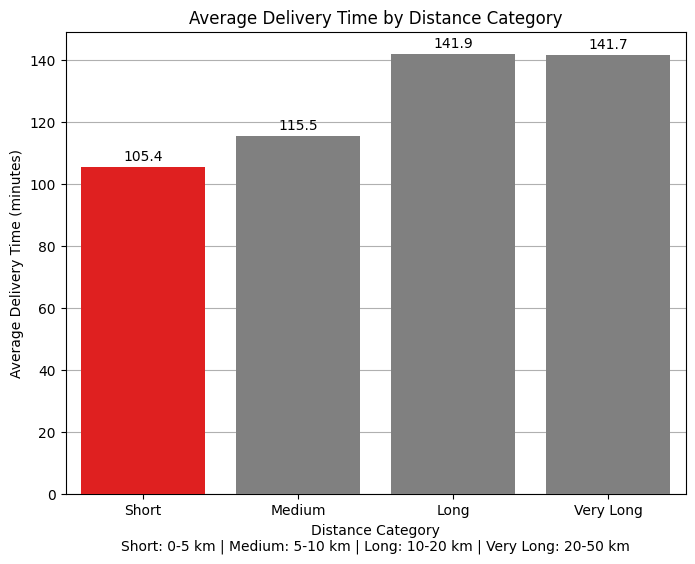

In [17]:
# Define bins and labels
bins = [0, 5, 10, 20, 50]
labels = ['Short', 'Medium', 'Long', 'Very Long']
df['Distance_Category'] = pd.cut(df['Distance_km'], bins=bins, labels=labels)

# Group by Distance_Category and calculate average delivery time
distance_summary = df.groupby('Distance_Category')['Delivery_Time'].mean().reset_index()
print(distance_summary)

# Define custom colors: red for "Short" distance category, grey for others
colors = ['red' if category == 'Short' else 'grey' for category in distance_summary['Distance_Category']]

# Plotting
plt.figure(figsize=(8, 6))

# Set grid to be behind the bars
plt.grid(True, zorder=0)
barplot = sns.barplot(data=distance_summary, x='Distance_Category', y='Delivery_Time', palette=colors, zorder=3)
plt.title('Average Delivery Time by Distance Category')
plt.xlabel('Distance Category\nShort: 0-5 km | Medium: 5-10 km | Long: 10-20 km | Very Long: 20-50 km')
plt.ylabel('Average Delivery Time (minutes)')

# Add exact values on top of each bar
for index, row in distance_summary.iterrows():
    barplot.text(index, row['Delivery_Time'] + 2, f"{row['Delivery_Time']:.1f}", ha='center', zorder=4)

plt.show()



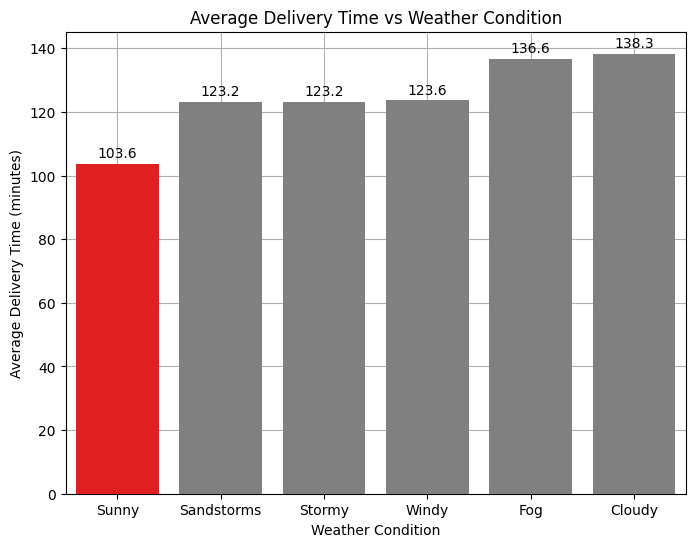

In [20]:
# Calculate the average delivery time by weather condition
average_delivery_time_by_weather = df.groupby('Weather')['Delivery_Time'].mean().reset_index()

# Sort the DataFrame in ascending order of Delivery_Time
average_delivery_time_by_weather = average_delivery_time_by_weather.sort_values(by='Delivery_Time', ascending=True)

# Extract the sorted weather conditions
sorted_weather_conditions = average_delivery_time_by_weather['Weather'].tolist()

# Define custom colors: red for "Sunny" weather, grey for others (adjust as needed)
colors = ['red' if weather == 'Sunny' else 'grey' for weather in sorted_weather_conditions]

# Plotting with custom colors
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=average_delivery_time_by_weather, x='Weather', y='Delivery_Time', order=sorted_weather_conditions, palette=colors, zorder=3)
plt.title('Average Delivery Time vs Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Delivery Time (minutes)')
plt.grid(True, zorder=0)  # Add grid lines

# Add exact values on top of each bar for weather condition plot
for index, row in enumerate(average_delivery_time_by_weather.itertuples()):
    barplot.text(index, row.Delivery_Time + 2, f"{row.Delivery_Time:.1f}", ha='center', zorder=4)

plt.show()

## Multi-variable graph: Delivery Time by Traffic Level and Area

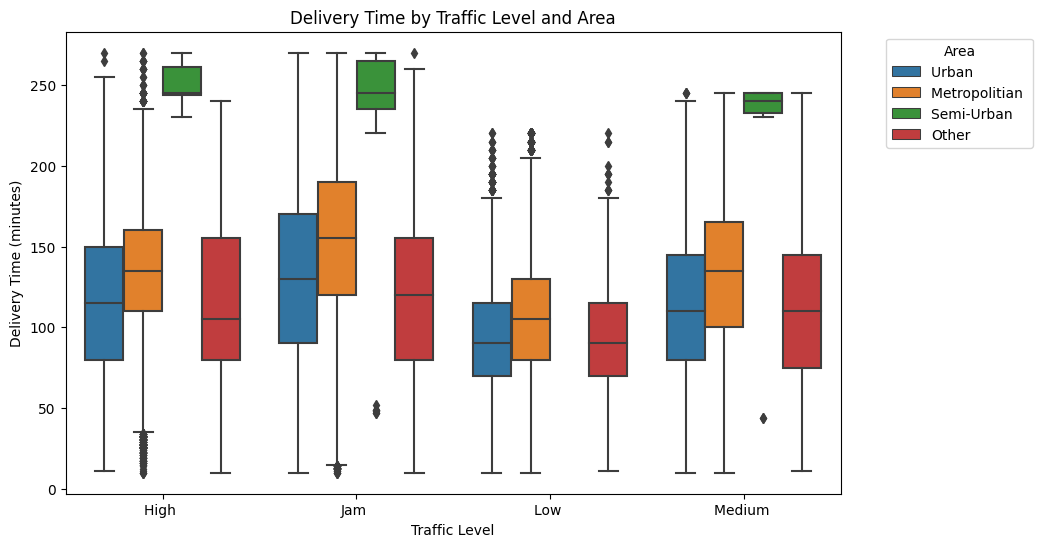

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Traffic', y='Delivery_Time', hue='Area')
plt.title('Delivery Time by Traffic Level and Area')
plt.xlabel('Traffic Level')
plt.ylabel('Delivery Time (minutes)')
plt.legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Urban areas perform better, suggesting that supplier hubs in urban areas could be more efficient.
Metropolitan areas need better traffic management or route optimization tools to reduce delivery delays.

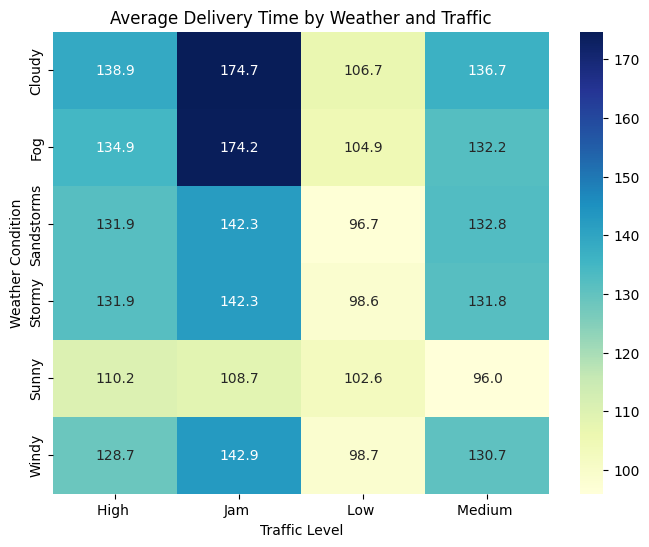

In [ ]:
#a pivot table for delivery time by weather and traffic
heatmap_data = df.pivot_table(
    values='Delivery_Time', 
    index='Weather', 
    columns='Traffic', 
    aggfunc='mean'
)

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Average Delivery Time by Weather and Traffic')
plt.xlabel('Traffic Level')
plt.ylabel('Weather Condition')
plt.show()

Heatmap:
Deliveries during jammed traffic and bad weather (e.g., fog, cloudy conditions) tend to have significantly higher delivery times.
Sunny weather and low/medium traffic exhibit the lowest delivery times.
Fog with traffic jams has the highest average delivery time, showing weather and congestion are critical bottlenecks.
Insight:
Suppliers could optimize scheduling by avoiding dispatch during peak traffic hours in bad weather conditions.

# Step 3: Additional Feature Engineering
## Extract Time-Based Features

In [ ]:
#Extract hour from order time
df['Order_Hour'] = df['Order_DateTime'].dt.hour

#Extract day of the week (0=monday, 6=sunday)
df['Order_DayOfWeek'] = df['Order_DateTime'].dt.dayofweek

# Create a new column for part of day
def get_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Part_of_Day'] = df['Order_Hour'].apply(get_part_of_day)
print(df[['Order_DateTime', 'Order_Hour', 'Order_DayOfWeek', 'Part_of_Day']].head())
print(df.head())

       Order_DateTime  Order_Hour  Order_DayOfWeek Part_of_Day
0 2022-03-19 11:30:00          11                5     Morning
1 2022-03-25 19:45:00          19                4     Evening
2 2022-03-19 08:30:00           8                5     Morning
3 2022-04-05 18:00:00          18                1     Evening
4 2022-03-26 13:30:00          13                5   Afternoon
        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time Pickup_Time     Weather  Traffic      Vehicle            Area  Delivery_Time     Category      Order_DateTime     Pickup_DateTime  Order_Pickup_Lag  Distance_km Distance_Category  Order_Hour  Order_DayOfWeek Part_of_Day
0  ialx566343618         37           4.9       22.745049        75.892471      22.765049       75.912471 2022-03-19   11:30:00    11:45:00       Sunny    High   motorcycle           Urban             120     Clothing 2022-03-19 11:30:00 2022-03-19 11:45:00              15.

## Define peak hours (10am-8pm)

In [ ]:
def is_peak_hour(hour):
    return 10 <= hour <= 20

df['Is_Peak_Hour'] = df['Order_Hour'].apply(is_peak_hour)
print(df[['Order_Hour', 'Is_Peak_Hour']].head())

   Order_Hour  Is_Peak_Hour
0          11          True
1          19          True
2           8         False
3          18          True
4          13          True


## Analyze Delivery Performance by New Features

In [ ]:
# Group by Part of Day and calculate average delivery time
part_of_day_summary = df.groupby('Part_of_Day')['Delivery_Time'].mean().reset_index()
print(part_of_day_summary)

# Group by Is_Peak_Hour and calculate average delivery time
peak_hour_summary = df.groupby('Is_Peak_Hour')['Delivery_Time'].mean().reset_index()
print(peak_hour_summary)

  Part_of_Day  Delivery_Time
0   Afternoon     122.102806
1     Evening     138.857866
2     Morning     101.126125
3       Night     121.091662
   Is_Peak_Hour  Delivery_Time
0         False     115.162366
1          True     131.690481


## Visualize New Features’ Impact on Delivery Time

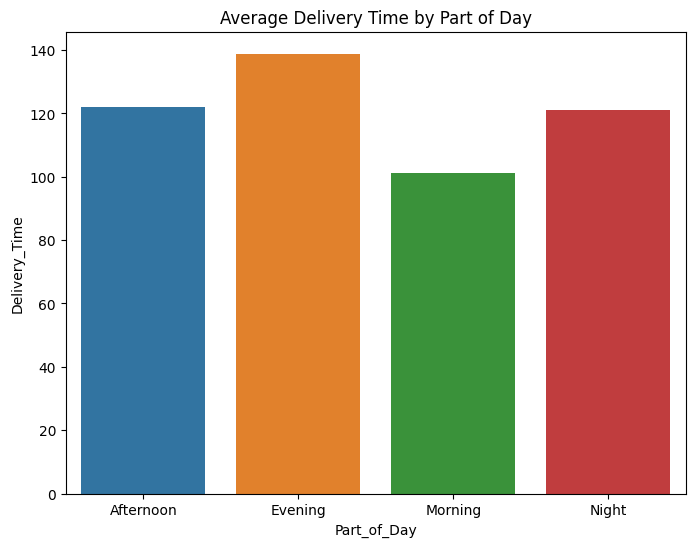

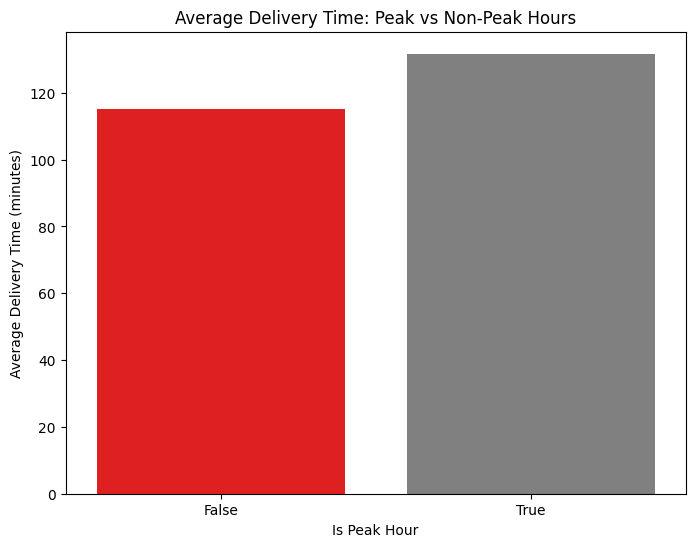

In [ ]:
# peak hour vs delivery time
# which part of day vs delivery time
# day of week vs delivery time

#delivery time by part of day
plt.figure(figsize=(8, 6))
sns.barplot(data=part_of_day_summary, x='Part_of_Day', y='Delivery_Time')
plt.title('Average Delivery Time by Part of Day')
plt.show()

# Define custom colors: grey for peak, red for non-peak
colors = ['grey' if peak else 'red' for peak in peak_hour_summary['Is_Peak_Hour']]

# Plot with custom colors
plt.figure(figsize=(8, 6))
sns.barplot(data=peak_hour_summary, x='Is_Peak_Hour', y='Delivery_Time', palette=colors)
plt.title('Average Delivery Time: Peak vs Non-Peak Hours')
plt.xlabel('Is Peak Hour')
plt.ylabel('Average Delivery Time (minutes)')
plt.show()


   Order_DayOfWeek  Delivery_Time        Day
0                0     124.785450     Monday
1                1     120.304534    Tuesday
2                2     131.669815  Wednesday
3                3     119.794113   Thursday
4                4     126.927457     Friday
5                5     124.967983   Saturday
6                6     124.967391     Sunday


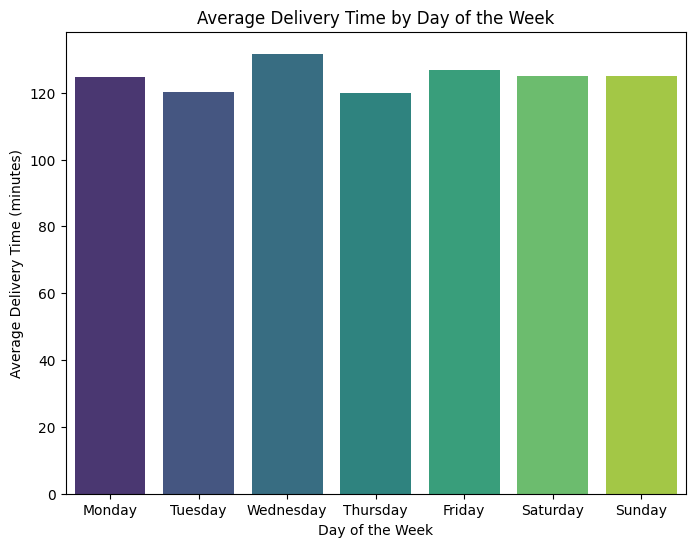

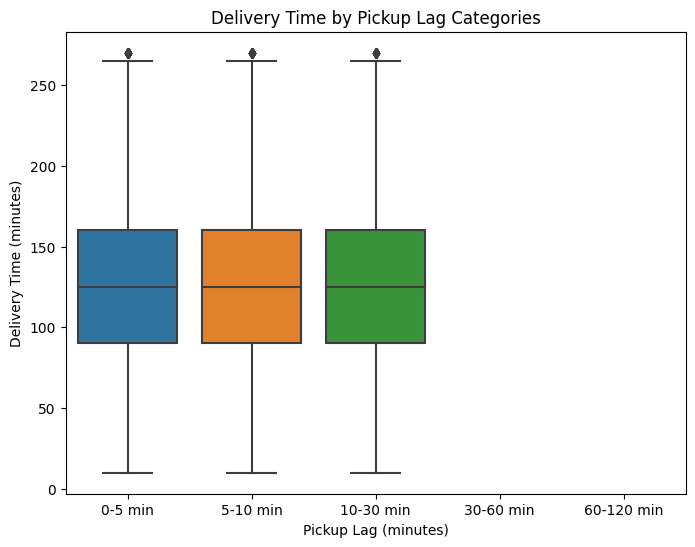

In [ ]:
day_of_week_summary = df.groupby('Order_DayOfWeek')['Delivery_Time'].mean().reset_index()

day_of_week_summary['Day'] = day_of_week_summary['Order_DayOfWeek'].map(
    {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
)

print(day_of_week_summary)

#delivery time by day of the week
plt.figure(figsize=(8, 6))
sns.barplot(data=day_of_week_summary, x='Day', y='Delivery_Time', palette='viridis')
plt.title('Average Delivery Time by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delivery Time (minutes)')
plt.show()


#Create bins for pickup lag to group into categories
df['Pickup_Lag_Category'] = pd.cut(df['Order_Pickup_Lag'], bins=[0, 5, 10, 30, 60, 120], 
                            labels=['0-5 min', '5-10 min', '10-30 min', '30-60 min', '60-120 min'])

#Boxplot to visualize delivery time across pickup lag categories
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Pickup_Lag_Category', y='Delivery_Time')
plt.title('Delivery Time by Pickup Lag Categories')
plt.xlabel('Pickup Lag (minutes)')
plt.ylabel('Delivery Time (minutes)')
plt.show()

## Correlation Between Features

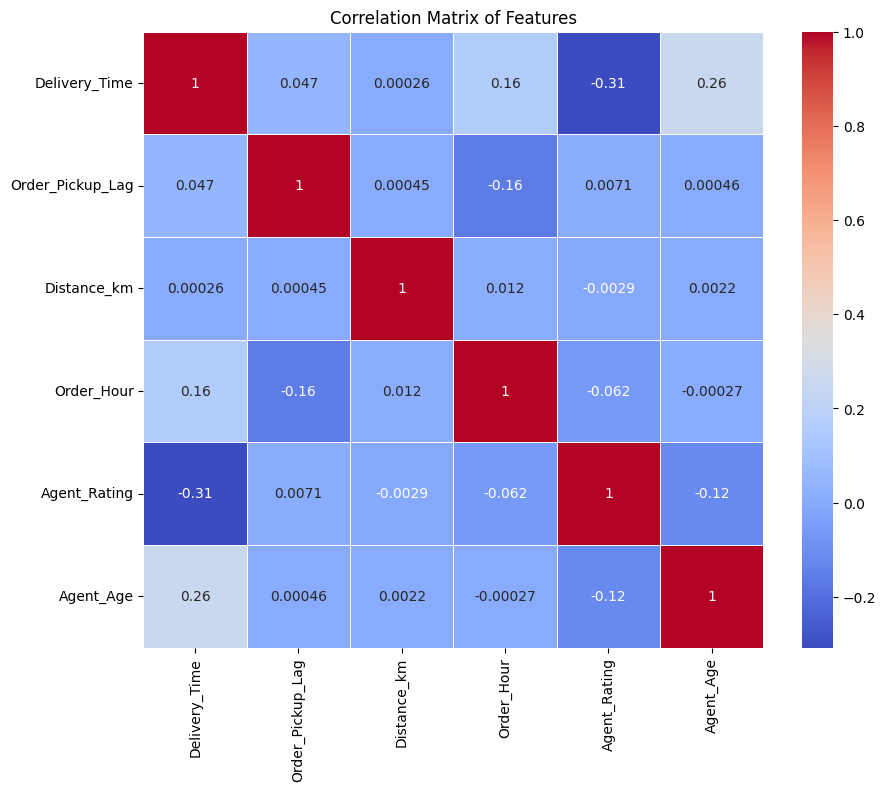

In [ ]:
correlation_matrix = df[['Delivery_Time', 'Order_Pickup_Lag', 'Distance_km', 'Order_Hour', 
                         'Agent_Rating', 'Agent_Age']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


## Relationships that have >0.1 correlation

### Order_Hour and Delivery_Time
There is a small positive correlation (0.16) between Order_Hour and Delivery_Time, which implies that deliveries made later in the day may take slightly longer.
This could be due to factors like peak traffic hours or increased order volumes during certain times of the day.

### Agent_Rating and Delivery_Time
Moderate negative correlation (-0.31). Higher-rated agents tend to complete deliveries faster.
This could suggest that agent experience or skill (reflected in higher ratings) positively impacts delivery efficiency.


### Agent_Age and Delivery_Time: 
Weak positive correlation (0.26). Older agents may have a slight tendency to deliver faster.

## Final Datset

In [ ]:
print(df.head())
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)  
pd.set_option('display.max_colwidth', None) 


        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time Pickup_Time     Weather  Traffic      Vehicle            Area  Delivery_Time     Category      Order_DateTime     Pickup_DateTime  Order_Pickup_Lag  Distance_km Distance_Category  Order_Hour  Order_DayOfWeek Part_of_Day  Is_Peak_Hour Pickup_Lag_Category
0  ialx566343618         37           4.9       22.745049        75.892471      22.765049       75.912471 2022-03-19   11:30:00    11:45:00       Sunny    High   motorcycle           Urban             120     Clothing 2022-03-19 11:30:00 2022-03-19 11:45:00              15.0     3.025149             Short          11                5     Morning          True           10-30 min
1  akqg208421122         34           4.5       12.913041        77.683237      13.043041       77.813237 2022-03-25   19:45:00    19:50:00      Stormy     Jam      scooter   Metropolitian             165  Electronics 2022-03-25 19:45:0

## Values needed for presentation

In [ ]:
# Calculate the average delivery time for agents with rating >= 4.5 vs those with rating < 4.5
high_rating_avg_time = df[df['Agent_Rating'] >= 4.5]['Delivery_Time'].mean()
low_rating_avg_time = df[df['Agent_Rating'] < 4.5]['Delivery_Time'].mean()

# Calculate the percentage difference in delivery time
percentage_increase = ((low_rating_avg_time - high_rating_avg_time) / low_rating_avg_time) * 100

# Display results
print("Average Delivery Time (Rating >= 4.5):", high_rating_avg_time)
print("Average Delivery Time (Rating < 4.5):", low_rating_avg_time)
print("Percentage Difference in Delivery Time:", percentage_increase, "%")

Average Delivery Time (Rating >= 4.5): 115.50756255271295
Average Delivery Time (Rating < 4.5): 166.62549850448653
Percentage Difference in Delivery Time: 30.67833939617422 %


In [ ]:
print("Unique values in 'Traffic' column:", df['Traffic'].unique())


Unique values in 'Traffic' column: ['High ' 'Jam ' 'Low ' 'Medium ']


In [ ]:
# Ensure that 'Traffic' column is of string type before stripping whitespace
df['Traffic'] = df['Traffic'].astype(str).str.strip()

# Now you can proceed with the grouping and calculations as before
df['Traffic_Group'] = df['Traffic'].replace({'Low': 'Low', 'Medium': 'Medium-High-Jam', 'High': 'Medium-High-Jam', 'Jam': 'Medium-High-Jam'})

# Calculate average delivery time for each traffic group
traffic_group_summary = df.groupby('Traffic_Group')['Delivery_Time'].mean().reset_index()
traffic_group_summary.rename(columns={'Delivery_Time': 'Average_Delivery_Time'}, inplace=True)

# Display the grouped summary to confirm correct grouping and values
print("Traffic group summary:\n", traffic_group_summary)

# Attempt to extract the average delivery times with error handling
try:
    low_time = traffic_group_summary[traffic_group_summary['Traffic_Group'] == 'Low']['Average_Delivery_Time'].values[0]
    medium_high_jam_time = traffic_group_summary[traffic_group_summary['Traffic_Group'] == 'Medium-High-Jam']['Average_Delivery_Time'].values[0]

    # Calculate the natural percentage decrease in delivery time from Medium-High-Jam to Low
    percentage_decrease = ((medium_high_jam_time - low_time) / medium_high_jam_time) * 100

    # Display results
    print("Average Delivery Time (Low Traffic):", low_time)
    print("Average Delivery Time (Medium-High-Jam Traffic):", medium_high_jam_time)
    print("Percentage Decrease in Delivery Time from Medium-High-Jam to Low Traffic:", percentage_decrease, "%")

except IndexError:
    print("Error: One of the traffic groups (Low or Medium-High-Jam) is missing from the data.")


Traffic group summary:
      Traffic_Group  Average_Delivery_Time
0              Low             101.352965
1  Medium-High-Jam             137.247362
Average Delivery Time (Low Traffic): 101.35296474358974
Average Delivery Time (Medium-High-Jam Traffic): 137.24736180026557
Percentage Decrease in Delivery Time from Medium-High-Jam to Low Traffic: 26.153068872035963 %


In [ ]:
# Clean the Part_of_Day column
df['Part_of_Day'] = df['Part_of_Day'].str.strip().str.title()

# Print unique values after cleaning to verify
print("Unique values in 'Part_of_Day' column:", df['Part_of_Day'].unique())

# Calculate the average delivery time for Morning + Night and Evening + Afternoon
morning_night_avg = df[df['Part_of_Day'].isin(['Morning', 'Night'])]['Delivery_Time'].mean()
evening_afternoon_avg = df[df['Part_of_Day'].isin(['Evening', 'Afternoon'])]['Delivery_Time'].mean()

# Calculate the percentage decrease in delivery time
percentage_decrease = ((evening_afternoon_avg - morning_night_avg) / evening_afternoon_avg) * 100

# Display the results
print(f"Average Delivery Time (Morning + Night): {morning_night_avg:.2f} minutes")
print(f"Average Delivery Time (Evening + Afternoon): {evening_afternoon_avg:.2f} minutes")
print(f"Percentage Decrease in Delivery Time: {percentage_decrease:.2f}%")

Unique values in 'Part_of_Day' column: ['Morning' 'Evening' 'Afternoon' 'Night']
Average Delivery Time (Morning + Night): 114.07 minutes
Average Delivery Time (Evening + Afternoon): 135.76 minutes
Percentage Decrease in Delivery Time: 15.98%


# Step 4: Predictive Modeling
## Prepare the Data for Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
for column in ['Traffic', 'Weather', 'Vehicle', 'Area']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Save the encoders for future use

#Define features X and y
X = df[['Agent_Age', 'Agent_Rating', 'Distance_km', 'Order_Pickup_Lag', 'Traffic', 'Weather', 'Vehicle', 'Area']]
y = df['Delivery_Time']

#80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training Linear R

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on test 
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2046.5378120116166
R-squared: 0.22179577664069516


## Train decision trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the decision tree regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on test
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'Decision Tree - Mean Squared Error: {mse_dt}')
print(f'Decision Tree - R-squared: {r2_dt}')

Decision Tree - Mean Squared Error: 2500.2416848262415
Decision Tree - R-squared: 0.049273056607604504


## Interpret results

            Feature  Importance
2       Distance_km    0.292664
1      Agent_Rating    0.210768
5           Weather    0.164757
0         Agent_Age    0.134809
4           Traffic    0.111103
3  Order_Pickup_Lag    0.036296
6           Vehicle    0.030939
7              Area    0.018664


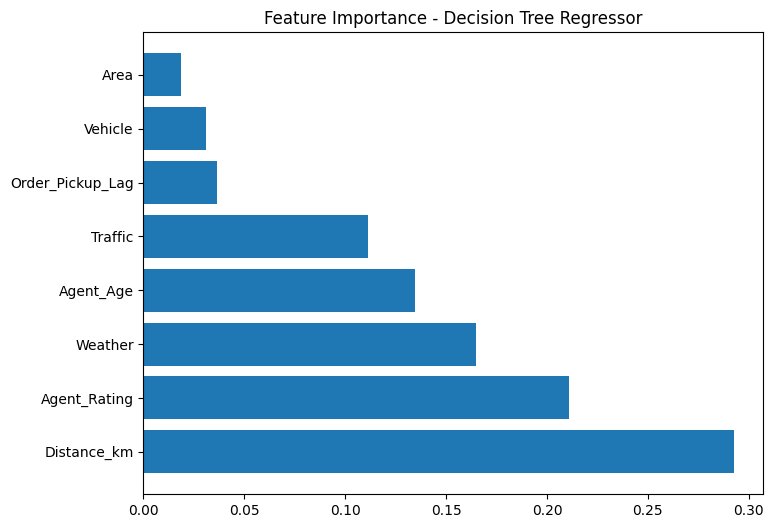

In [ ]:
# Feature importance for Decision Tree
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance - Decision Tree Regressor')
plt.show()

## Plot Linear regression model

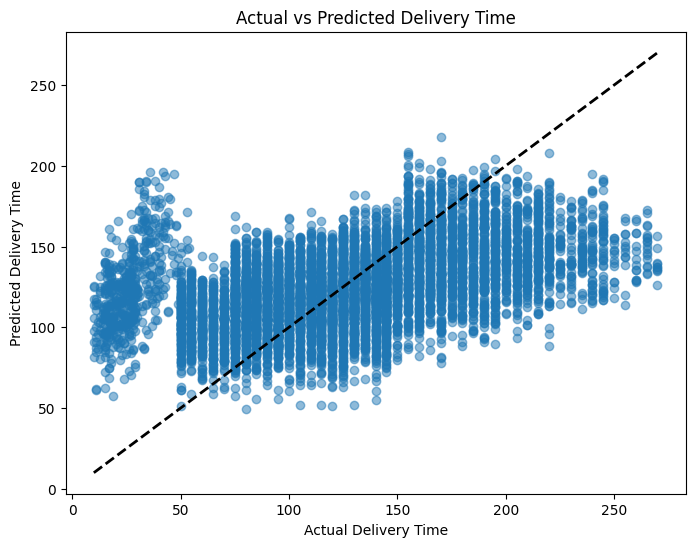

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted Delivery Time')
plt.show()

## Analyze Model Coefficient in LR

<Figure size 800x600 with 0 Axes>

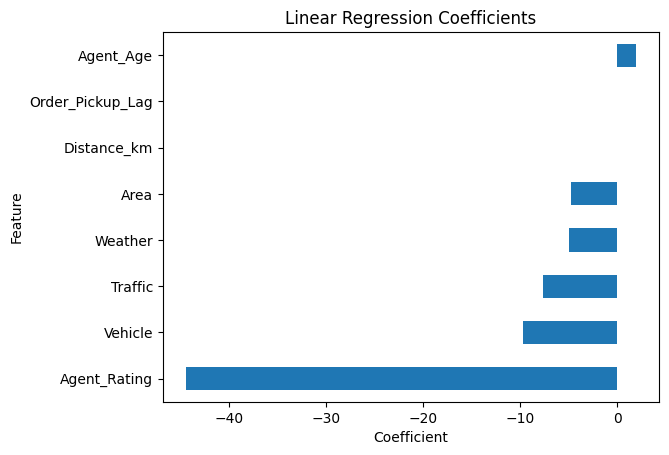

In [ ]:
# Arrange coefficients from low to high
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

# Sort the coefficients in ascending order
coefficients = coefficients.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients for visualization
plt.figure(figsize=(8, 6))
coefficients.plot(kind='barh', x='Feature', y='Coefficient', legend=False)
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()


## Key Factors affecting delivery time:

### 1.	Agent_Rating:
Linear Regression: Strong negative effect (higher rating = shorter delivery times).  
Decision Tree: High importance, agent rating is a key factor.

### 2.	Distance_km:
Linear Regression: Near zero coefficient, indicating little to no linear effect.  
Decision Tree: Highest importance, suggesting that distance has a non-linear effect on delivery time.  
Insight: The Decision Tree captures non-linear patterns that the linear model cannot. This could explain why distance is more impactful in the decision tree-based model.

### 3.	Traffic and Weather:
Both models agree that traffic and weather moderately affect delivery time.  
Insight: Traffic and weather impact deliveries, but not as much as agent-related factors or distance.

### 4.	Agent_Age and Order_Pickup_Lag:
Both models assign low importance to these features.  
Insight: Agent age and pickup lag don’t appear to significantly influence delivery time.

### 5.	Vehicle and Area:
Both models show minimal influence for these features.  
Insight: Different types of vehicles or store areas seem to have little effect on delivery time, possibly due to well-distributed deliveries.



## Optimization Strategies:

### 1.	Assign High-Rated Agents to Priority Deliveries
Unexpectedly, Agent rating was identified as a key driver in both models, with higher-rated agents consistently delivering faster.  
•	Assign high-rated agents to time-sensitive or high-priority deliveries.  
•	Use a performance-based allocation system to ensure critical deliveries are handled by top-performing agents.  
  
Expected Outcome:  
•	Improve customer satisfaction by reducing delays.  
•	Ensure faster delivery for high-priority orders.  

### 2.	Use Route Optimization for Longer Distances  
Distance had a non-linear impact on delivery times, as identified by the decision tree model.  
•	Implement route optimization tools (e.g., Google Maps API, GPS tracking) to minimize travel distances.  
•	Use dynamic route adjustments based on real-time traffic data.  
•	Group deliveries going to similar areas to reduce the number of trips.  
  
Expected Outcome:  
•	Reduce travel time and fuel costs.  
•	Improve delivery efficiency for long-distance routes.  

### 3.	 Adjust Staffing and Delivery Schedules Based on Traffic and Weather  
Traffic and weather both moderately influence delivery times.  
•	Monitor real-time traffic and weather conditions to adjust delivery schedules.  
•	Increase the number of available agents during peak traffic hours.  
•	Pre-schedule deliveries during off-peak hours where possible to avoid delays.  
  
Expected Outcome:  
•	Minimize delays caused by congestion or weather.  
•	Reduce idle time for agents during off-peak periods.  

### 4.	Focus on Reducing Pickup Lag Where Possible  
While pickup lag didn’t play a large role, reducing it could still slightly improve delivery performance.  
•	Streamline the pickup process by ensuring agents arrive at the store on time.  
•	Introduce automated notifications to alert agents when orders are ready for pickup.  
•	Pre-pack orders to minimize waiting time at the store.  
  
Expected Outcome:  
•	Marginal improvements in delivery time.  
•	Better customer experience by minimizing avoidable delays.  

### 5.	Monitor Key Metrics and Improve Continuously  
Track metrics such as delivery time, order-pickup lag, agent performance, and on-time delivery rates.  

